## Описание проекта

Энергетический оракул

**Задача**

Разработка модели прогнозирования почасового энергопотребления региона на сутки, в МВт*ч.

**Цель**

Разработать надежную и точную модель прогнозирования объема почасового энергопотребления на следующие сутки для Калининградской области с использованием доступных исторических данных и соответствующих переменных.

**Описание задачи**   

В данной задаче необходимо разработать предиктивную модель, которая позволит прогнозировать энергопотребление региона на основе имеющихся данных о потреблении электроэнергии в прошлом и соответствующих факторах, влияющих на потребление энергии. Модель должна быть способна учесть сезонные, временные и другие зависимости для более точного прогноза.

Замечание (!) Если мы делаем прогноз на сегодня, то у нас есть все данные за вчера и более ранние, но нет данных из будущего. Учесть это при конструировании признаков для модели.

**Описание данных**

Для создания кейса использовались реальные данные.

**Обучающий датасет**
содержит данные за период 2019 -01 -01– 2023 -03 -31

**Публичный тестовый датасет**
представляет продолжение обучающего датасета. Содержит данные за период 2023-04-01 – 2023-07-31

**Приватный тестовый датасет**
содержит данные за период 2023-08-01 – 2023-09-30

**Признаки:**

date – дата

time – время, время представлено в диапазоне 0 – 23, что означает 24 часа в сутках

temp – фактическая температура на указанную дату

temp _pred _pred_pred – прогноз температуры на указанную дату

weather_fact– фактическая погода на указанную дату

weather_pred – прогноз погоды на указанную дату

**Целевой признак:**

target – Фактическое потребление на указанную дату

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* разведочный анализ,
* разработка новых признаков,   
* отбор финального набора обучающих признаков,   
* выбор и обучение моделей,   
* итоговая оценка качества предсказания лучшей модели,   
* анализ важности ее признаков,  
* общий вывод.


Импортируем необходимые библиотеки 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit


import warnings
import time

#from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
#from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf

## Первичный обзор данных
Считаем данные из csv-файлов в датафрейм и сохраним в переменную train и test .

In [2]:
train = pd.read_csv('train_dataset.csv', parse_dates=[0],index_col='date')
test = pd.read_csv('test_dataset.csv', parse_dates=[0],index_col='date')

In [3]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

In [4]:
print(f'Исходный датасет')
print(f'Количество строк {train.shape[0]}')
print(f'Количество столбцов {train.shape[1]}')

Исходный датасет
Количество строк 37224
Количество столбцов 6


In [5]:
print(f'Тестовый датасет')
print(f'Количество строк {test.shape[0]}')
print(f'Количество столбцов {test.shape[1]}')

Тестовый датасет
Количество строк 2928
Количество столбцов 6


In [6]:
# напишем функцию для вывода основной информации о датасете
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Тип признаков')
    print(data.dtypes)

In [7]:
# посмотрим обучающий датасет
main_info(train)

Выведем первые 5 строк датафрейма


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 to 2023-03-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB


None


Количество строк-дубликатов


0


Тип признаков
time              int64
target          float64
temp            float64
temp_pred       float64
weather_pred     object
weather_fact     object
dtype: object


In [8]:
# изучим тестовые данные
main_info(test)

Выведем первые 5 строк датафрейма


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 to 2023-07-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB


None


Количество строк-дубликатов


0


Тип признаков
time              int64
target          float64
temp            float64
temp_pred       float64
weather_pred     object
weather_fact     object
dtype: object


Проверим наши временные ряды на отсутствие пропусков и последовательность.

In [9]:
# проверим на монотонность
if train.index.is_monotonic_increasing:
    print("Индекс монотонно возрастающий")
else:
    print("Индекс не монотонно возрастающий")

Индекс монотонно возрастающий


In [10]:
if test.index.is_monotonic_increasing:
    print("Индекс монотонно возрастающий")
else:
    print("Индекс не монотонно возрастающий")

Индекс монотонно возрастающий


**Вывод после первичного обзора и загрузки обучающих и тестовых данных:**

обучающий датасет содержит 37224 объектов и 7 столбцов(признаков);

названия колонок соответствуют первоначальному описанию данных;

типы данных: 4 столбца это численные признаки (int64,float64) и 3 столбца это категориальные(object);
требуется изменить тип данных в столбце `date` и провести 'нормализацию'

в данных обнаружены пропуски: столбец temp_pred, weather_pred и weather_fact(обработаем если будет необходимо позднее);

строки с явными дубликатами отсутствуют;

из описания данных видно, что все столбцы достаточно информативны, но использовать при прогнозе столбцы с фактической температурой и погодой недопустимо, т.к. будет утечка данных при построении модели и если мы делаем прогноз на сегодня, то у нас нет данных из будущего о фактической температуре и погоде. Мы можем оперировать только прогнозными значениями;

целевой признак - столбец target .

## Исследовательский анализ данных

Перед нами стоит задача регрессии, в которой модель должна предсказывать почасовое потребление региона на следующие сутки (24 часа).
Наши данные представлены с требуемым интервалом - 1 час.

Рассмотрим зависимость нашего таргета от временного интервала, исследуем данные на наличие сезонности и тренда.

В целях подготовки и изучения данных проведем исследовательский анализ данных (EDA), который состоит из следующих этапов:

изучение целевого признака;
изучение признаков для обучения;
изучение влияния признаков на таргет;
разработка новых синтетических признаков и изучение корреляции.
отбор финального набора обучающих признаков.

Изучим целевой признак

In [11]:
df = train.copy()
df = train.drop(['time', 'temp', 'temp_pred', 'weather_pred', 'weather_fact'], axis=1)

In [12]:
df.head()

,target
date,
2019-01-01,481.510
2019-01-01,462.872
2019-01-01,449.718
2019-01-01,430.908
2019-01-01,415.163


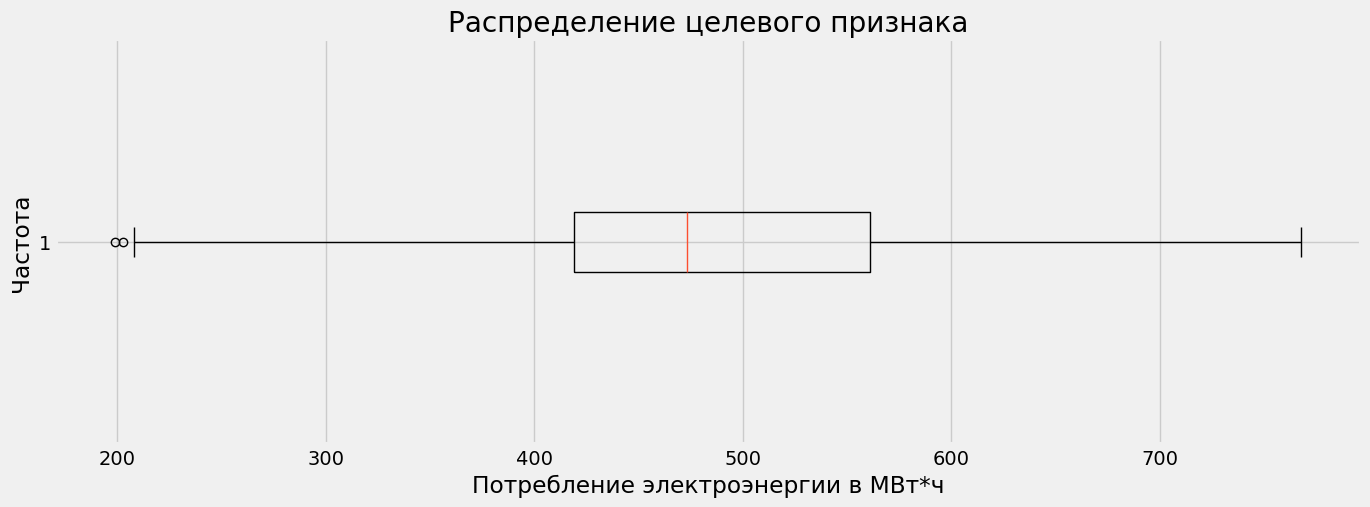

In [13]:
plt.figure(figsize=(15,5))
plt.boxplot(df['target'],vert = False);
plt.title ('Распределение целевого признака');
plt.xlabel ('Потребление электроэнергии в МВт*ч');
plt.ylabel ('Частота');

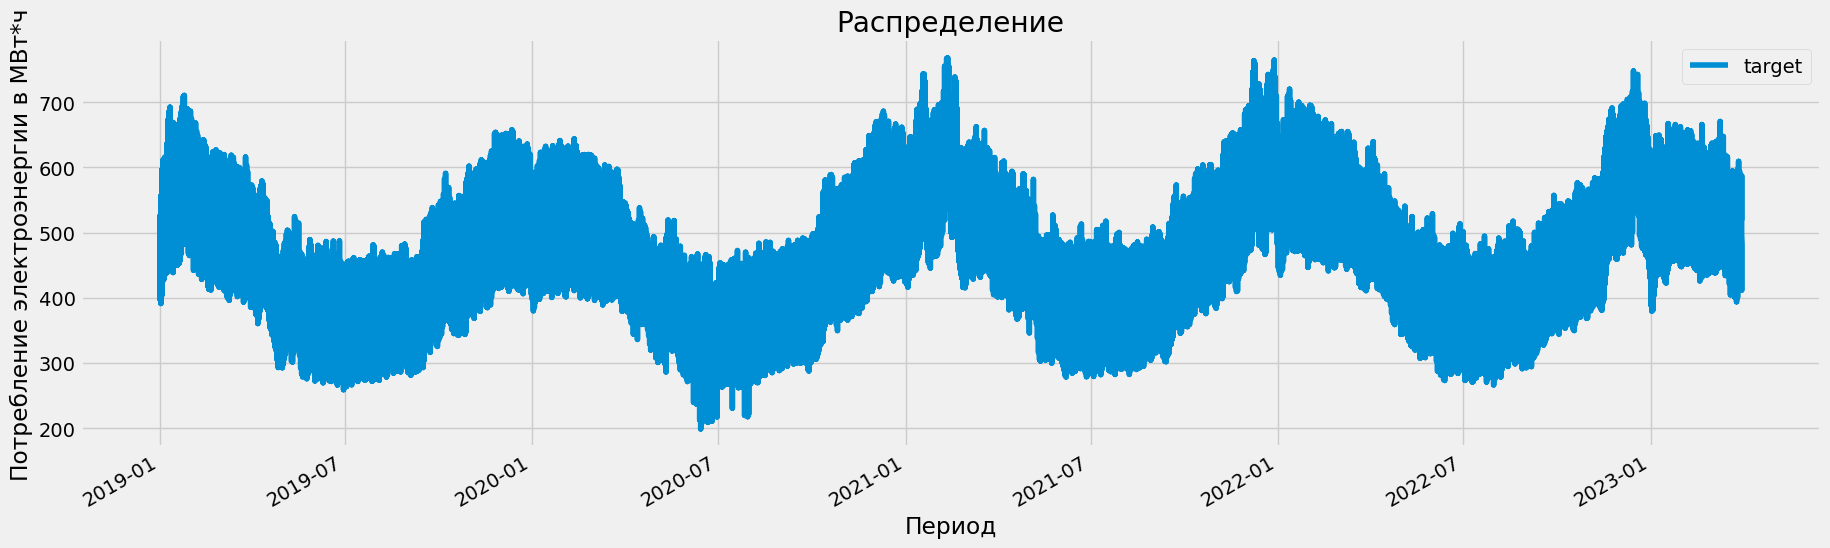

In [14]:
# посмотрим на распределение наших данных во времени
df.plot(figsize=(20,6));
plt.title ('Распределение');
plt.xlabel ('Период');
plt.ylabel ('Потребление электроэнергии в МВт*ч');

In [15]:
df['target'].describe()

count    37224.000000
mean       483.731441
std        101.459375
min        198.982000
25%        418.950750
50%        473.064000
75%        561.217000
max        767.888000
Name: target, dtype: float64

Выбросов нет, в среднем почасовое энергопотребление Калининградской области находится на уровне 483,73 МВт*ч.

Посмотрим корреляцию таргета с другими признаками.

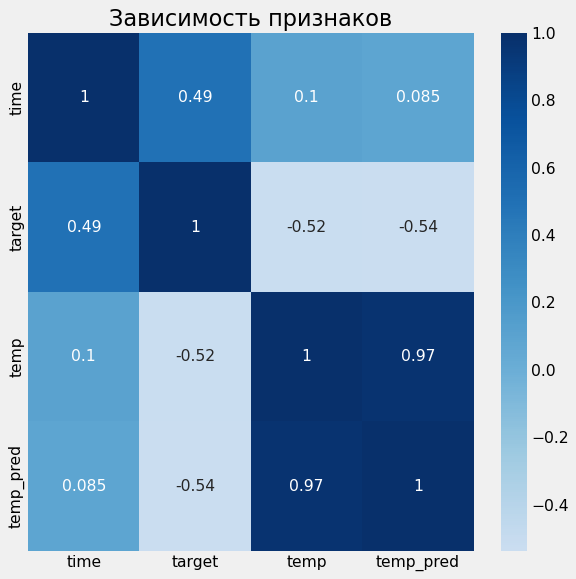

In [16]:
plt.figure(figsize=(8,8), dpi= 80)
sns.heatmap(train.corr(),cmap='Blues', center=0, annot=True)
plt.title('Зависимость признаков')
plt.show()

Наибольшая отрицательная линейная зависимость наблюдается между таргетом и прогнозом температуры (-0.54). Далее сильная положительная зависимость видна между таргетом и временем (0,49).

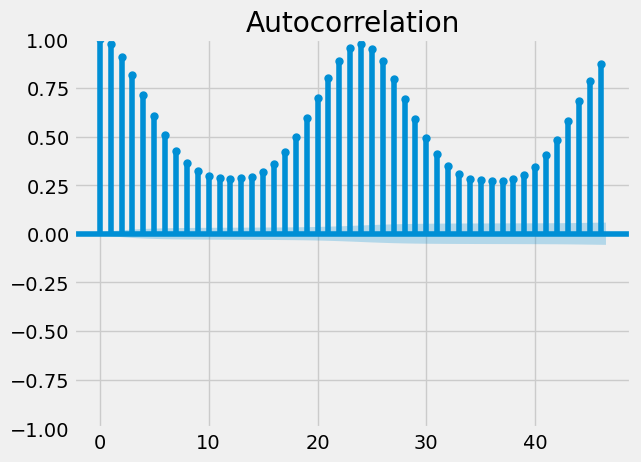

In [17]:
# импортируем функцию для построения автокорреляционной функции (ACF)
# применим ее к данным о таргете, добавим лаги за 24 часа
plot_acf(df['target'])
plt.show()

In [18]:
# проведем ресемплирование данных по 24 часа
df = df.resample('24h').sum()

Выполним декомпозицию ряда на тренд, циклические составляющие и случайный шум. Построим графики.

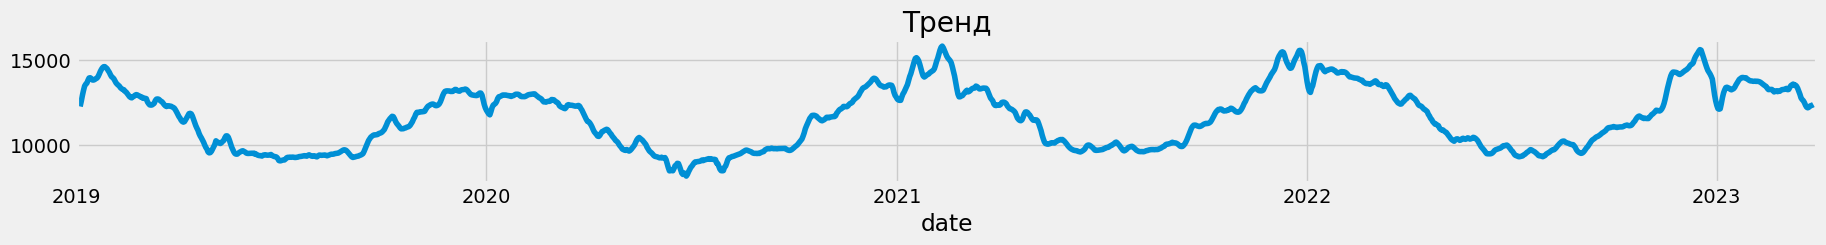

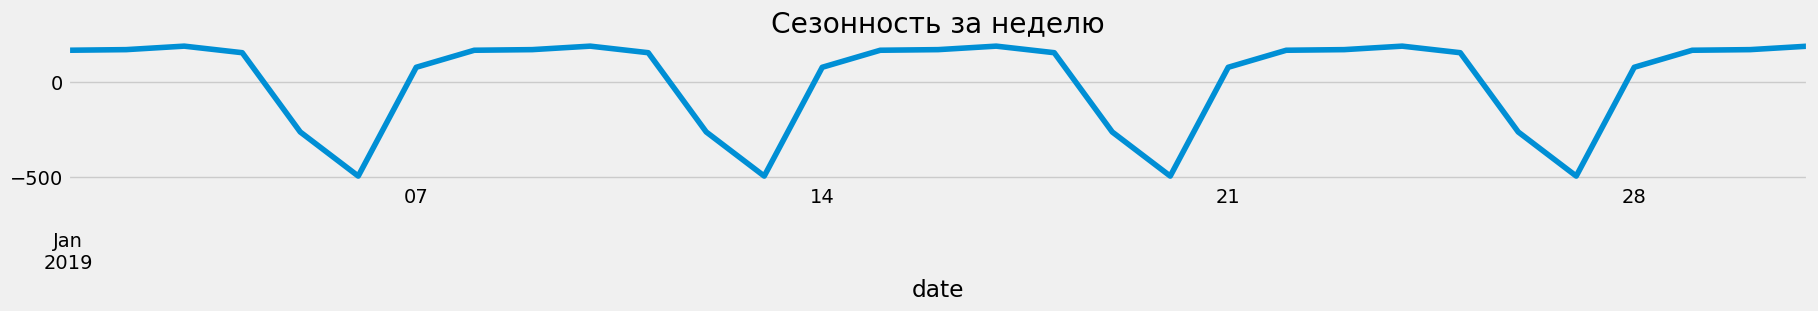

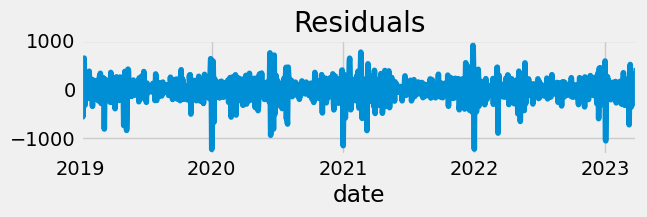

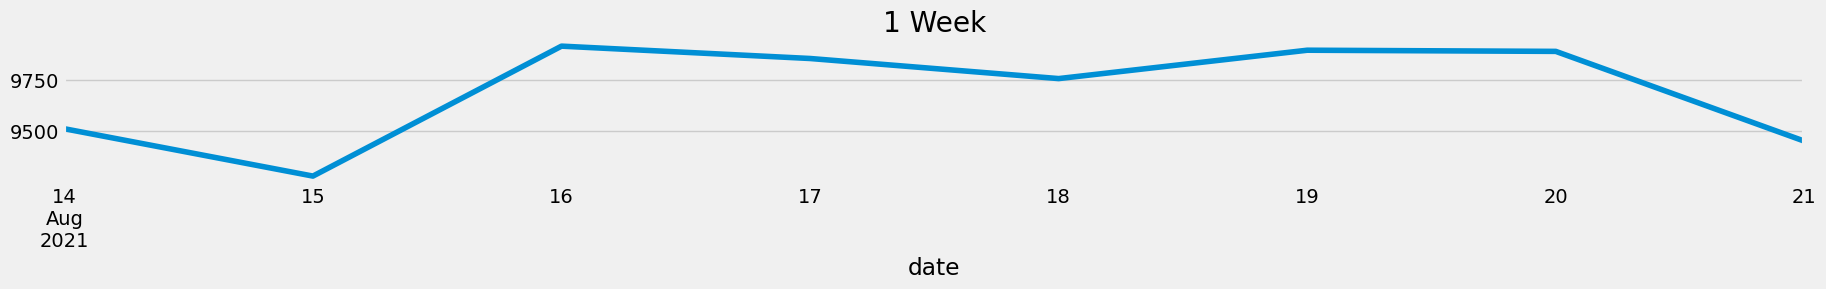

In [19]:
decomposed = seasonal_decompose(df)

# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.show()

#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.head(31).plot(ax=plt.gca())  
#decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность за неделю')
plt.show()
#

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.show()

#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df.loc['2021-08-14':'2021-08-21','target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()


Тест Дики-Фуллера на стационарность¶

In [20]:
ts = df['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.792721
p-value: 0.402297
Critical Values:
	1%: -4.379
	5%: -3.836
	10%: -3.556


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины.

Далее мы создадим функции, в которых будем добавлять различные признаки и тестировать их при обучении модели.
Данный процесс реализован в отдельном ноутбуке "model_fitting".